<a href="https://colab.research.google.com/github/Pmskabir1234/RNN/blob/main/RNN_Tensorflow_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#stimulating synthetic weather data

np.random.seed(42)
days = 500
tmax = 30 + 5 * np.sin(np.linspace(0, 20, days)) + np.random.randn(days)
tmin = 20 + 3 * np.sin(np.linspace(0, 20, days)) + np.random.randn(days)
rain = np.random.choice([0, 1], size=days, p=[0.7, 0.3])  # 0 = no rain, 1 = rain

df = pd.DataFrame({
    "tmax": tmax,
    "tmin": tmin,
    "rain": rain
})

# create target = next day's tmax
df["tmax_tomorrow"] = df["tmax"].shift(-1)
df.dropna(inplace=True)

print(df.head())

        tmax       tmin  rain  tmax_tomorrow
0  30.496714  20.926178     0      30.062083
1  30.062083  22.029625     0      31.048061
2  31.048061  18.841656     0      32.122785
3  32.122785  20.922822     1      30.564020
4  30.564020  19.828262     0      30.761174


In [ ]:
#feature scaling

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
x_all = []
y_all = []
seq_len = 5

for i in range(len(df) - seq_len):
  x_all.append(scaled[i: i+seq_len, :3])
  y_all.append(scaled[i+seq_len,3])

x_all = np.array(x_all)
y_all = np.array(y_all)

X_train,X_test,y_train,y_test = train_test_split(x_all,y_all,test_size=0.25,shuffle=False)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (370, 5, 3)
y_train shape: (370,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN

#Building the model
model = Sequential([
    SimpleRNN(64,activation = 'tanh', input_shape = (seq_len,3), return_sequences=False),
    Dense(32,activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,465 (25.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(
    X_train,y_train,
    epochs = 50,
    batch_size = 16,
    validation_split = 0.1,
    verbose = 0
)

#Model evaluation in scaled space
test_loss,test_mae = model.evaluate(X_test,y_test)
print(f'Test Loss: {test_loss} & Test MAE: {test_mae}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


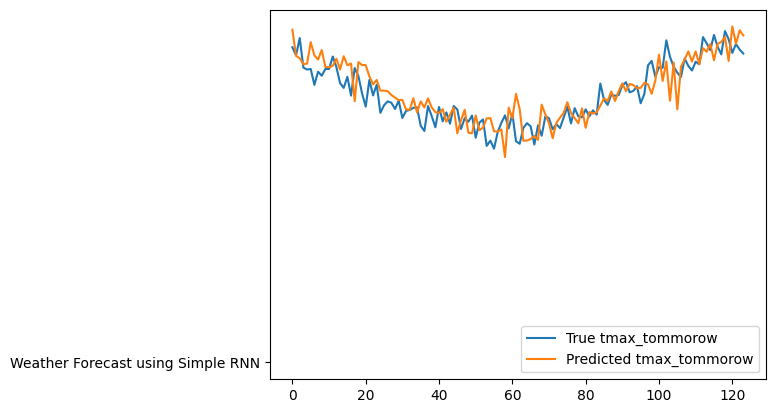

In [ ]:
#Making Predictions
y_pred = model.predict(X_test)

#invert scaling for interpretability
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test),3)), y_test.reshape(-1,1)], axis = 1)
)[:,3]
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred),3)), y_pred], axis = 1)
)[:,3]


plt.plot(y_test_rescaled, label='True tmax_tommorow')
plt.plot(y_pred_rescaled, label='Predicted tmax_tommorow')
plt.legend()
plt.plot("Weather Forecast using Simple RNN")
plt.show()

In [33]:
#Model evaluation in non-scaled (real-data) space
from sklearn.metrics import mean_absolute_error

real_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'Real Mean Absoule Error: {real_mae}')

Real Mean Absoule: 1.4039916122334357
